# doc2vec modelling of abstracts

1. Prepare training corpus
2. Train doc2vec model 
3. Reduce model dimensions and visualize

Load libraries.

In [194]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
import multiprocessing as mp
from timeit import default_timer as timer
from datetime import timedelta
import seaborn as sns
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1. Prepare training corpus 

*Note: Need to split into training and test portions, which I didn't do here, to be able to test. Need to test different hyperparameters.*

Load metadata.

In [153]:
meta = pd.read_csv('data/arxiv_metadata_astroph.csv')
meta

/home/bkh4324/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,identifier,filename,spec,title,datestamp,created,updated,authors,categories,journal,doi,abstract,comments,date_retrieved,filename_parsed
0,oai:arXiv.org:0704.0009,704.001,physics:astro-ph,"The Spitzer c2d Survey of Large, Nearby, Inste...",2010-03-18,2007-04-02,NaN,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...",astro-ph,"Astrophys.J.663:1149-1173,2007",10.1086/518646,We discuss the results from the combined IRA...,NaN,2020-03-07 02:10:36.300743,704.001
1,oai:arXiv.org:0704.0017,704.002,physics:astro-ph,Spectroscopic Observations of the Intermediate...,2009-06-23,2007-03-31,NaN,"Nceba Mhlahlo, David H. Buckley, Vikram S. Dhi...",astro-ph,"Mon.Not.Roy.Astron.Soc.378:211-220,2007",10.1111/j.1365-2966.2007.11762.x,Results from spectroscopic observations of t...,NaN,2020-03-07 02:10:36.300743,704.002
2,oai:arXiv.org:0704.0023,704.002,physics:astro-ph,ALMA as the ideal probe of the solar chromosphere,2009-06-23,2007-03-31,NaN,"M. A. Loukitcheva, S. K. Solanki, S. White",astro-ph,"Astrophys.Space Sci.313:197-200,2008",10.1007/s10509-007-9626-1,"The very nature of the solar chromosphere, i...",NaN,2020-03-07 02:10:36.300743,704.002
3,oai:arXiv.org:0704.0044,704.004,physics:astro-ph,Astrophysical gyrokinetics: kinetic and fluid ...,2015-05-13,2007-03-31,2009-05-09,"A. A. Schekochihin, S. C. Cowley, W. Dorland, ...",astro-ph nlin.CD physics.plasm-ph physics.spac...,"ApJS 182, 310 (2009)",10.1088/0067-0049/182/1/310,We present a theoretical framework for plasm...,NaN,2020-03-07 02:10:36.300743,704.004
4,oai:arXiv.org:0704.0048,704.005,physics:astro-ph,Inference on white dwarf binary systems using ...,2008-11-26,2007-03-31,2007-04-03,"Alexander Stroeer, John Veitch, Christian Roev...",gr-qc astro-ph,"Class.Quant.Grav.24:S541-S550,2007",10.1088/0264-9381/24/19/S17,We report on the analysis of selected single...,NaN,2020-03-07 02:10:36.300743,704.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267789,oai:arXiv.org:quant-ph/9903043,quant-ph/9903043,physics:astro-ph,A Possible Anisotropy in Blackbody Radiation V...,2007-05-23,1999-03-12,1999-06-07,T K Rai Dastidar,quant-ph astro-ph hep-th,Mod.Phys.Lett. A14 (1999) 1193-1198,NaN,A non-local gauge symmetry of a complex scal...,NaN,2020-03-07 02:10:36.300743,quant-ph9903043
267790,oai:arXiv.org:quant-ph/9903053,quant-ph/9903053,physics:astro-ph,Father Time. I. Does the Cosmic Microwave Back...,2009-10-31,1999-03-15,1999-10-21,T K Rai Dastidar,quant-ph astro-ph hep-th,Mod.Phys.Lett. A14 (1999) 2499-2505,10.1142/S0217732399002601,The existence of a non-thermodynamic arrow o...,NaN,2020-03-07 02:10:36.300743,quant-ph9903053
267791,oai:arXiv.org:quant-ph/9907088,quant-ph/9907088,physics:astro-ph,On Bures fidelity of displaced squeezed therma...,2008-12-18,1999-07-27,NaN,"Xiang-Bin Wang, C. H. Oh, L. C. Kwek",quant-ph astro-ph,"Phys.Rev.A58:4186,1998",10.1103/PhysRevA.58.4186,Fidelity plays a key role in quantum informa...,NaN,2020-03-07 02:10:36.300743,quant-ph9907088
267792,oai:arXiv.org:solv-int/9404002,solv-int/9404002,physics:astro-ph,Dynamical Systems Accepting the Normal Shift,2008-02-03,1993-04-07,NaN,R. A. Sharipov,solv-int alg-geom astro-ph gr-qc hep-th math.A...,NaN,NaN,Newtonian dynamical systems accepting the no...,NaN,2020-03-07 02:10:36.300743,solv-int9404002


Collect the abstracts that we will train doc2vec on:

In [ ]:
data = [abstract.replace('\n', ' ') for abstract in meta['abstract']]
len(data)

Tokenize each abstract. (Removes no stopwords.)

In [ ]:
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(data)]

In [ ]:
train_corpus[0]

## 2. Train doc2vec model

Set up doc2vec model parameters.

- dm = 0 means "distributed bag of words" (PV-DBOW). dm = 1 means "distributed memory" (PV-DM)

In [ ]:
model = Doc2Vec(vector_size=300,
                alpha=0.025,
                min_alpha=0.001, 
                min_count=1,
                workers=mp.cpu_count(),
                dm=1,
                epochs=40)

model.build_vocab(train_corpus)

Train model for 100 epochs. 

In [ ]:
start = timer()
max_epochs = 100

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

model.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

## 3. Reduce model dimensions and visualize

### Load model

In [140]:
model = Doc2Vec.load('d2v.model')
print('Dimensions of each document in this model: ' + str(len(model[0])))

Dimensions of each document in this model: 300


Get the document IDs.

In [142]:
doc_tags = list(model.docvecs.doctags.keys())
len(doc_tags)

267794

Get the documents from the model.

In [143]:
docs = model[doc_tags]
len(docs)

267794

### Generate labels

Collect categories from metadata.

In [154]:
categories = meta['categories'].str.split(' ')
categories

0                                                [astro-ph]
1                                                [astro-ph]
2                                                [astro-ph]
3         [astro-ph, nlin.CD, physics.plasm-ph, physics....
4                                         [gr-qc, astro-ph]
                                ...                        
267789                         [quant-ph, astro-ph, hep-th]
267790                         [quant-ph, astro-ph, hep-th]
267791                                 [quant-ph, astro-ph]
267792    [solv-int, alg-geom, astro-ph, gr-qc, hep-th, ...
267793    [solv-int, astro-ph, chao-dyn, comp-gas, nlin....
Name: categories, Length: 267794, dtype: object

Generate labels for subdomains.

In [248]:
acceptable_subdomains = ['astro-ph.SR',
                         'astro-ph.CO',
                         'astro-ph.GA',
                         'astro-ph.HE',
                         'astro-ph.EP',
                         'astro-ph.IM']

subdomain_names = ['Solar and Stellar Astrophysics', # for plot legend
                     'Cosmology and Nongalactic Astrophysics',
                     'Astrophysics of Galaxies',
                     'High Energy Astrophysical Phenomena',
                     'Earth and Planetary Astrophysics',
                     'Instrumentation and Methods for Astrophysics'] 

acceptable_categories = ['astro-ph']
acceptable_categories += acceptable_subdomains

category_names = ['Astrophysics']
category_names += subdomain_names

Find each paper's author-assigned subcategory. If the paper has none, remove it from the data. We will not plot it. 

In [235]:
labels = []
indexes_to_drop = []

# For each paper
for i, _ in enumerate(categories):
    # For each category
    for j,_ in enumerate(categories[i]):
        assigned = False
        
        # If category is a subcategory, select it as the paper's label (this grabs the first one)
        if categories[i][j] in acceptable_subdomains:
            labels.append(subdomain_names[acceptable_subdomains.index(categories[i][j])])
            assigned = True
            break
            
        # If on last category,
        if j == (len(categories[i]) - 1) and not assigned: 
            indexes_to_drop.append(i)    
            
print('Dropping ' + str(len(indexes_to_drop)) + ' papers.')
print('Labels: ' + str(len(labels)))
pd.Series(labels).value_counts()

Dropping 105283 papers.
Labels: 162511


Cosmology and Nongalactic Astrophysics          41667
Solar and Stellar Astrophysics                  33334
High Energy Astrophysical Phenomena             29932
Astrophysics of Galaxies                        29689
Earth and Planetary Astrophysics                14684
Instrumentation and Methods for Astrophysics    13205
dtype: int64

Also find each paper's assigned category (and subcategory, as this includes astro-ph). 

In [255]:
labels_full = []
for i, _ in enumerate(categories): 
    for j,_ in enumerate(categories[i]):
        if categories[i][j] in acceptable_categories:
            labels_full.append(category_names[acceptable_categories.index(categories[i][j])])
            break
            
pd.Series(labels_full).value_counts()

Astrophysics                                    105362
Cosmology and Nongalactic Astrophysics           41635
Solar and Stellar Astrophysics                   33328
High Energy Astrophysical Phenomena              29925
Astrophysics of Galaxies                         29682
Earth and Planetary Astrophysics                 14669
Instrumentation and Methods for Astrophysics     13193
dtype: int64

Generate array of label colors (used for 3D plots, they have a different argument requirement). 

In [217]:
colors = ['red', 'black', 'blue', 'purple', 'orange', 'yellow', 'green', 'brown']
label_indices = []
for label in labels:
    label_indices.append(subdomain_names.index(label))
label_indices

[3,
 4,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 2,
 0,
 3,
 1,
 1,
 4,
 0,
 3,
 3,
 0,
 1,
 3,
 1,
 1,
 5,
 1,
 4,
 3,
 5,
 5,
 2,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 2,
 1,
 4,
 1,
 0,
 0,
 2,
 1,
 3,
 1,
 1,
 5,
 3,
 1,
 5,
 2,
 3,
 3,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 5,
 1,
 1,
 4,
 1,
 3,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 5,
 1,
 3,
 5,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 0,
 2,
 3,
 0,
 3,
 3,
 5,
 0,
 1,
 2,
 0,
 0,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 3,
 3,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 5,
 1,
 2,
 3,
 3,
 0,
 1,
 2,
 4,
 1,
 1,
 2,
 2,
 3,
 3,
 5,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 2,
 1,
 3,
 2,
 5,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 0,
 3,
 4,
 0,
 1,
 4,
 2,
 3,
 0,
 3,
 0,
 4,
 3,
 5,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 3,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 4,
 0,
 0,
 1,
 2,
 4,
 0,
 0,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 2,
 3,
 1,
 0,
 2,
 1,
 0,
 1,
 5,
 3,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 5,
 2,
 3,
 0,


### PCA

Generate, from the original 300 dimensions, the first three principal components.

In [145]:
pca = PCA(n_components=3)
pca_result_3 = pca.fit_transform(docs)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0163555  0.01512518 0.01315541]


The first three components account for about 4.44% of the variation in the entire dataset. This seems low. We will need to see if it is enough to visually set the different documents apart. We can do this by creating a scatterplot of the principal components and coloring each document's subdomain with a different color. If documents from the same subdomain are clustered together in groups, this would mean that the first three principal components actually tell us a great deal about the specific subdomains of documents.

Remove papers that don't have author-assigned subdomain. *(Would it be better to remove before PCA?)*

In [163]:
pca_result_3.shape

(267794, 3)

In [164]:
pca_result_3_mod = np.delete(pca_result_3, indexes_to_drop, axis=0)
pca_result_3_mod.shape

(162511, 3)

Visualize 2D.

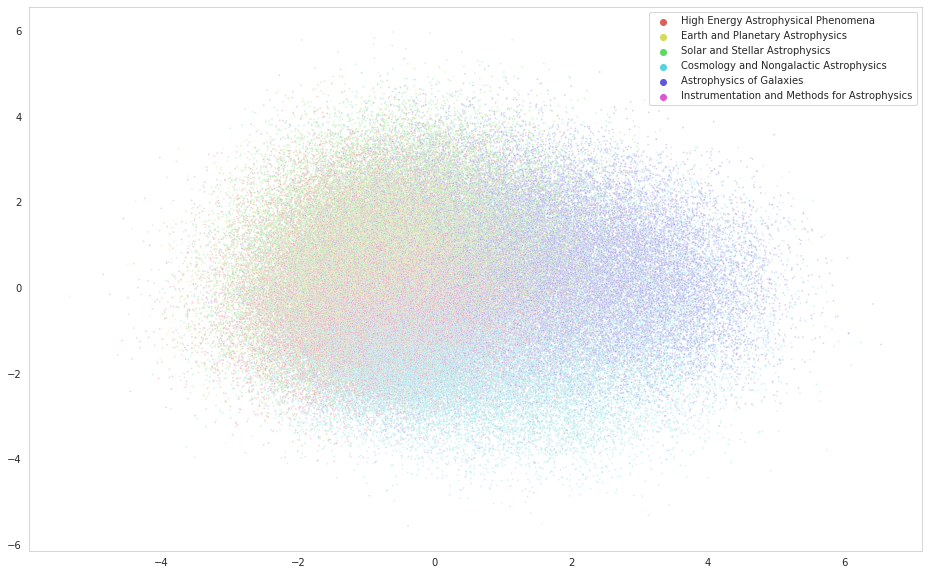

In [254]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result_3_mod[:,0],
    y=pca_result_3_mod[:,1],
    alpha=0.3,
    s=3,
    hue=labels,
    palette=sns.color_palette("hls", len(subdomain_names))
)

Visualize 3D.

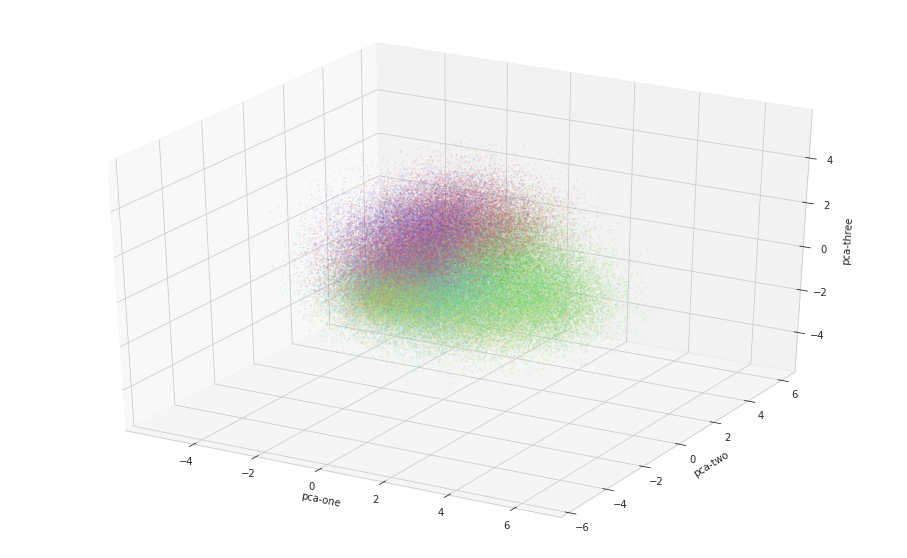

In [219]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result_3_mod[:,0], 
    ys=pca_result_3_mod[:,1], 
    zs=pca_result_3_mod[:,2], 
    c=label_indices, 
    alpha=0.1,
    cmap=ListedColormap(sns.color_palette("hls", len(subdomain_names))),
    s=0.5
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

From the graphs we can see the first two components definitely hold some information, but not enough to set all of the documents apart. *Not sure if the two plots are colored the same. I tried, but it doesn't look the same. Would be helpful to somehow open up into the matplotlib interactive window and explore.*

### t-SNE

t-SNE is another technique that we can use to reduce the number of dimensions that may prove more helpful than PCA.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or Truncated SVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.

Reduce from 300 dimensions to 50 using PCA.

In [ ]:
pca_full = PCA(n_components=50)
pca_result_full = pca_full.fit_transform(x_full)
len(pca_result_full)

Reduce from 50 dimensions to 2 using t-SNE. *Will need to reduce to 3 later.*

In [ ]:
tsne = TSNE(n_components=2, verbose=1)
x_tsne_full = tsne.fit_transform(pca_result_full)
np.save('tsne_full.npy', x_tsne_full)

If we have already reduced the model using t-SNE (which takes a few hours), load the reduced model.

In [203]:
tsne_data = np.load('tsne_full.npy')
len(tsne_data)

267794

Remove papers that don't have author-assigned subdomain. *(Would it be better to remove before t-SNE? Same question above with PCA.)*

In [204]:
tsne_data_mod = np.delete(tsne_data, indexes_to_drop, axis=0)
len(tsne_data_mod)

162511

Visualize in 2D.

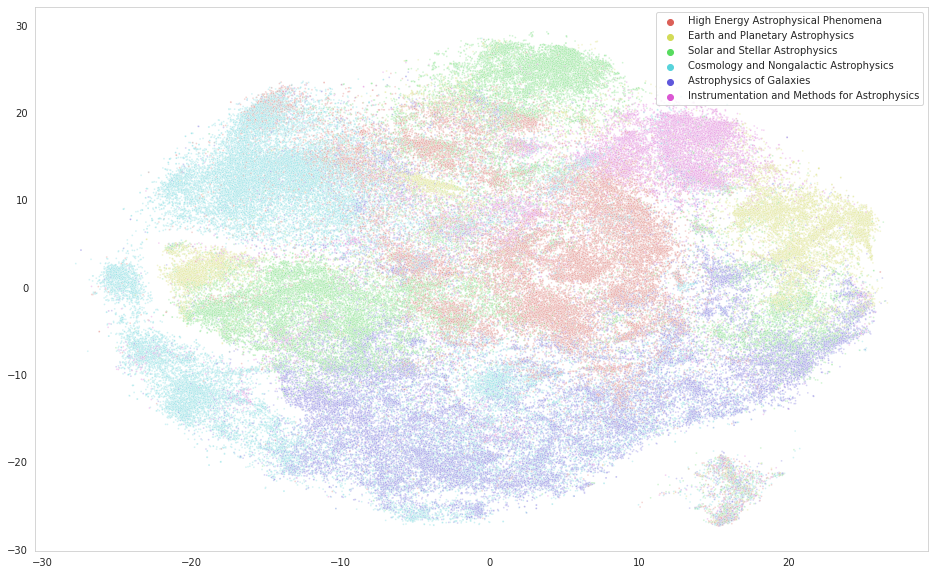

In [249]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne_data_mod],
    y=[i[1] for i in tsne_data_mod],
    alpha=0.3,
    s=3,
    hue=labels,
    legend='full',
    palette=sns.color_palette("hls", len(subdomain_names))
)

Visualize all categories in 2D.

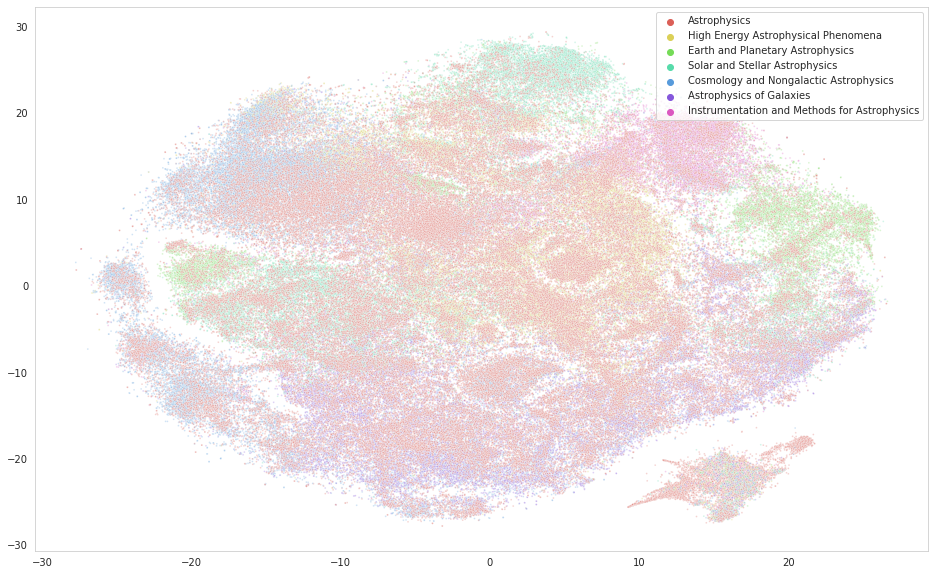

In [256]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne_data],
    y=[i[1] for i in tsne_data],
    alpha=0.3,
    hue=labels_full,
    s=3,
    legend='full',
    palette=sns.color_palette("hls", len(category_names))
)

*Could look at those astro-ph papers without subdomains to see if they are similar to whatever subdomain they were clustered into.*